# <center>제4고지 신경망 만들기</center>

# 37단계 텐서를 다루다

지금까지는 변수로 주로 '스칼라'를 다뤘으나 머신러닝 데이터로는 벡터나 행렬 등의 '텐서'가 주로 쓰이므로  
텐서를 사용할 때의 주의점을 알아보면서 DeZero의 확장을 준비

전에 구현한 add, mul 등의 함수는 원소별 계산이 이뤄짐

In [1]:
# example 1
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


In [2]:
# example 2
x = Variable(np.array([[1,2,3],[4,5,6]]))
c = Variable(np.array([[10,20,30],[40,50,60]]))
y = x + c
print(y)

variable([[11 22 33]
          [44 55 66]])


텐서를 이용해 역전파를 계산해도 문제 없음!  
이유는 다음과 같음
- 지금까지 구현한 DeZero 함수에 '텐서'를 건네면 텐서의 원소마다 '스칼라'로 계산함
- 텐서의 원소별 '스칼라' 계산이 이루어지면 '스칼라'를 가정해 구현한 역전파는 '텐서'의 원소별 계산에서도 성립함

텐서의 미분을 머신러닝에서는 '기울기'라고 함  
기울기의 형상과 데이터(순전파 때의 데이터)의 형상은 일치함  

__[보충] 텐서 사용 시의 역전파__

x와 y는 벡터이고, 두 벡터 모두 원소 수가 n개라고 가정하였을 때  
$y=F(x)$ 함수의 y의 x에 대한 미분은 다음과 같다.  
  
$\frac{\partial{y}}{\partial{x}}=\begin{pmatrix}
\frac{\partial{y_1}}{\partial{x_1}} & \frac{\partial{y_1}}{\partial{x_2}} & \cdots & \frac{\partial{y_1}}{\partial{x_n}}\\
\frac{\partial{y_2}}{\partial{x_1}} & \frac{\partial{y_2}}{\partial{x_2}} & \cdots & \frac{\partial{y_2}}{\partial{x_n}}\\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial{y_n}}{\partial{x_1}} & \frac{\partial{y_n}}{\partial{x_2}} & \cdots & \frac{\partial{y_n}}{\partial{x_n}}
\end{pmatrix}$  
  
x, y 모두 벡터이므로 그 미분은 위와 같이 '행렬'의 형태가 됨  
이 행렬을 야코비 행렬(Jacobian matrix)라고 함  
  
만약 y가 스칼라면 y의 x에 대한 미분은 다음과 같음  
$\frac{\partial{y}}{\partial{x}}=\begin{pmatrix}
\frac{\partial{y}}{\partial{x_1}} & \frac{\partial{y}}{\partial{x_1}} & \cdots & \frac{\partial{y}}{\partial{x_1}}
\end{pmatrix}$  
  
이는 1 $\times$ n의 야코비 행렬이며, 행 벡터(가로로 나열된 벡터)로 간주할 수 있음  
  
합성 함수 $y=F(x)$가 $a=A(x), b=B(a), y=C(b)$라는 3개의 함수로 구성되어 있고, x, a, b는 벡터이며 원소수가 모두 n개라고 가정하였을 때  
y의 x에 대한 미분은 연쇄 법칙에 의해 다음과 같음  
  
$\frac{\partial{y}}{\partial{x}}=\frac{\partial{y}}{\partial{b}}\frac{\partial{b}}{\partial{a}}\frac{\partial{a}}{\partial{x}}$  
  
여기서, $\frac{\partial{y}}{\partial{b}}\frac{\partial{b}}{\partial{a}}$는 야코비 행렬을 나타내며 '행렬의 곱'으로 계산함  
  
행렬곱을 계산하는 순서에는 두 가지 방법이 있음  
1. 자동 미분의 forward 모드 : 입력 쪽에서 출력 쪽으로 괄호를 친다.  
  
<img src='./img/4/forward_mode.png' width=400>  
  
중간의 행렬 곱의 결과가 다시 행렬이 됨  
ex) $\frac{\partial{b}}{\partial{a}}\frac{\partial{a}}{\partial{x}}$의 결과는 n $\times$ n 행렬  
  
2. 자동 미분의 reverse 모드 : 출력 쪽에서 입력 쪽으로 괄호를 친다.  
  
<img src='./img/4/reverse_mode.png' width=400>  
  
y가 스칼라이므로 중간의 행렬 곱의 결과는 모두 백터(행 벡터)가 됨  
따라서 벡터와 야코비 행렬의 곱으로 구성됨
ex) $\frac{\partial{y}}{\partial{b}}\frac{\partial{b}}{\partial{a}}$의 결과는 n개의 원소로 구성된 벡터  
  
행렬과 행렬의 곱보다 벡터와 행렬의 곱의 계산량이 적으므로 reverse 모드, 즉 역전파 쪽의 계산 효율이 좋음  
그렇기 때문에 역전파에서는 각 함수에 대해 벡터와 야코비 행렬의 곱을 계산함  
  


결과만 필요한 상황이라면 야코비 행렬을 구하여 '행렬의 곱'을 계산할 필요가 없음  
  
$a=A(x)$가 원소별 연산을 수행한 경우를 가정(ex: a=sin(x))  
이 함수의 야코비 행렬은 다음과 같음  
  
$\begin{pmatrix}
\frac{\partial{a_1}}{\partial{x_1}} & 0 & \cdots & 0\\
0 & \frac{\partial{a_2}}{\partial{x_2}} & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \frac{\partial{a_n}}{\partial{x_n}}
\end{pmatrix}$
  
위와 같이 원소별 연산의 야코비 행렬은 대각 행렬(대각 성분 외에는 모두 0인 행렬)이 됨  
$x_i$는 $a_i$에만 영향을 주기 때문  
  
또한, 야코비 행렬이 대각 행렬이라면 벡터와 야코비 행렬의 곱은 다음과 같음  
  
$\frac{\partial{y}}{\partial{a}}\frac{\partial{a}}{\partial{x}}=
\begin{pmatrix}
\frac{\partial{y}}{\partial{a_1}} & \frac{\partial{y}}{\partial{a_2}} & \cdots & \frac{\partial{y}}{\partial{a_n}}
\end{pmatrix} 
\begin{pmatrix}
\frac{\partial{a_1}}{\partial{x_1}} & 0 & \cdots & 0\\
0 & \frac{\partial{a_2}}{\partial{x_2}} & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \frac{\partial{a_n}}{\partial{x_n}}
\end{pmatrix}
=\begin{pmatrix}
\frac{\partial{y}}{\partial{a_1}}\frac{\partial{a_1}}{\partial{x_1}} & \frac{\partial{y}}{\partial{a_2}}\frac{\partial{a_2}}{\partial{x_2}} & \cdots & \frac{\partial{y}}{\partial{a_n}}\frac{\partial{a_n}}{\partial{x_n}}
\end{pmatrix}$  
  
위 식과 같이 최종 결과는 원소별 미분을 계산한 다음 그 결과값을 원소별로 곱하면 얻을 수 있음  
야코비 행렬을 구하여 '행렬의 곱'을 계산할 필요 없이 단순히 원소별로 곱하여 구할 수 있으며,  
따라서 더 효율적으로 계산(구현)할 수 있음


# 38단계 형상 변환 함수

원소별로 계산하지 않는 함수  
\* dezero/functions.py 에 추가
  
__reshape 함수 구현__  
  
텐서의 형상을 바꾸는 함수  
텐서의 원소 수는 같고 형상만 바뀜

In [3]:
import numpy as np

x = np.array([[1,2,3],[4,5,6]])
print(x)
y = np.reshape(x,(6,))
print(y)

[[1 2 3]
 [4 5 6]]
[1 2 3 4 5 6]


<img src='./img/4/reshape.png' width=400>

reshape 함수는 구체적인 계산 없이 단순히 형상만 변환함  
따라서 역전파도 기울기에 계산 없이 흘려보내는데, 변수의 데이터와 기울기의 형상이 일치해야 함  
ex) x가 Variable 인스턴스 일 때, x.data.shape == x.grad.shape이 만족할 수 있도록 역전파를 구현  
즉, 입력 변수 쪽의 형상에 맞게 변환하는 것이 reshape 함수의 역전파

~~~python
class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y
    
    def backward(self, gy):
        return reshape(gy, self.x_shape)
    
from dezero.core import as_variable

def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)
~~~

In [4]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


넘파이의 reshape은 다음과 같이 사용할 수도 있음

In [5]:
x = np.random.rand(1,2,3)

y = x.reshape((2,3)) # 튜플로 받기
y = x.reshape([2,3]) # 리스트로 받기
y = x.reshape(2,3) # 인수를 풀어서 받기

DeZero에서도 똑같은 용법을 제공하기 위해 Variable 클래스를 수정

~~~python
class Variable:
    ...
    
    def reshape(self, *shape): # 추가
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)
~~~

In [6]:
x = Variable(np.random.randn(1,2,3))
y = x.reshape((2,3))
y = x.reshape(2,3)

__행렬의 전치 함수 구현__  
  
행렬을 전치하면 행렬의 형상이 다음과 같이 변함  
  
ex)  
$x=\begin{pmatrix}x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}\end{pmatrix}$  
  
$x^T=\begin{pmatrix}x_{11} & x_{21}\\
x_{12} & x_{22}\\
x_{13} & x_{23}\end{pmatrix}$

In [7]:
# 넘파이의 transpose gkatn
x = np.array([[1,2,3],[4,5,6]])
y = np.transpose(x)
print(y)

[[1 4]
 [2 5]
 [3 6]]


텐서의 원소 자체는 그대로이고 형상만 바뀜  
따라서 역전파에서도 출력 쪽에서 전해지는 기울기의 형상만 순전파 때의 반대로 변경함  
\* 지금은 입력 변수가 행렬(2차원 텐서)일 때로 한정하여 구현

~~~python
class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y
    
    def backward(self, gy):
        gx = transpose(gy)
        return gx
    
def transpose(x):
    return Transpose()(x)
~~~

In [8]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


Variable 인스턴스에서도 transpose 함수를 사용할 수 있도록 수정

~~~python
class Variable:
    ...
    
    def transpose(self):
        return dezero.functions.transpose(self)
    
    @property # 인스턴스 변수로 사용할 수 있게 해주는 데코레이터
    def T(self):
        return dezero.functions.transpose(self)
~~~

In [9]:
x = Variable(np.random.rand(2,3))
y = x.transpose()
y = x.T

# [보충] 실제 transpose 함수  
  
넘파이의 np.transpose 함수는 다음과 같이 축의 데이터 순서를 바꿀 수 있음

<img src='./img/4/transpose.png' width=500>

In [10]:
A, B, C, D = 1, 2, 3, 4
x = np.random.rand(A, B, C, D)
print(x.shape)
y = x.transpose(1, 0, 3, 2) # 인덱스
print(y.shape)

(1, 2, 3, 4)
(2, 1, 4, 3)


위 코드에서 np.transpose에 건네지는 인수는 변환 후의 축 순서(인덱스)임  
인수를 None으로 주면 축이 역순으로 정렬됨(None이 기본값)  
  
Dezero에도 이를 반영

~~~python
class Transpose(Function):
    def __init__(self, axes=None):
        self.axes = axes

    def forward(self, x):
        y = x.transpose(self.axes)
        return y

    def backward(self, gy):
        if self.axes is None:
            return transpose(gy)

        axes_len = len(self.axes)
        inv_axes = tuple(np.argsort([ax % axes_len for ax in self.axes])) ### ???
        return transpose(gy, inv_axes)


def transpose(x, axes=None):
    return Transpose(axes)(x)
~~~

# 39단계 합계 함수

<img src='./img/4/add.png' width=400>

덧셈의 역전파는 출력 쪽에서 전해지는 기울기를 두 개로 '복사'하여 전달함  
이는 원소가 2개인 벡터를 사용해도 동일하게 이뤄짐

<img src='./img/4/sum_1.png' width=400>

위 그림은 2개의 원소로 구성된 벡터이며,  
이 벡터에 sum 함수를 적용하면 스칼라를 출력함  

<img src='./img/4/sum_2.png' width=400>

원소가 2개 이상인 벡터에서도 위 그림과 같이  
역전파에서 기울기를 입력 변수의 형상과 같아지도록 복사하여 벡터로 확장해 전파함  
입력 변수가 2차원 이상의 배열일 때도 동일하게 적용됨  
이것이 sum 함수의 역전파

\* sum 함수의 역전파에서 Variable 인스턴스를 사용하므로 복사 작업도 DeZero 함수로 해야하며,  
넘파이의 브로드캐스트와 같은 기능인 지정한 형상에 맞게 원소를 복사하는 작업은  
다음 단계에서 broadcast_to(x.shape)라는 함수로 구현할 예정  
sum 함수 구현을 위해 미리 사용함

~~~python
class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x):
    return Sum()(x)
~~~

In [11]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([1,2,3,4,5,6]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([1 1 1 1 1 1])


In [12]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([[1 1 1]
          [1 1 1]])


넘파이의 np.sum 함수는 합계를 구할 때 '축'을 지정하여 합계를 구할 방향을 정할 수 있음  
기본값인 None일 경우 모든 원소를 다 더한 값 하나를 스칼라로 출력하며,  
튜플로 지정하면 해당 튜플에서 지정한 축 모두에 대한 합계를 계산하고,  
0과 1일 경우는 아래 그림과 같음
  
<img src='./img/4/sum_3.png' width=400>

In [13]:
x = np.array([[1,2,3],[4,5,6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, '->', y.shape)

[5 7 9]
(2, 3) -> (3,)


또한 np.sum 함수는 keepdims라는 출력의 차원 수(축 수)를 동일하게 유지할지 정하는 인수도 받음  

In [14]:
x = np.array([[1,2,3],[4,5,6]])
y = np.sum(x, axis=0)
print(y)
y = np.sum(x, keepdims=True, axis=0)
print(y)
y = np.sum(x, keepdims=False, axis=0)
print(y)

[5 7 9]
[[5 7 9]]
[5 7 9]


위 두가지를 반영하여 Sum 클래스와 sum 함수를 수정

~~~python
from dezero import utils

class Sum(Function):
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)
~~~

utils.reshape_sum_backward 함수는 gy의 형상을 미세하게 조정함  
(axis와 keepdims를 지원하게 되면서 기울기의 형상을 변환하는 경우가 생기기 때문에 그에 대응하는 함수)

~~~python
def reshape_sum_backward(gy, x_shape, axis, keepdims):
    ndim = len(x_shape)
    tupled_axis = axis
    if axis is None:
        tupled_axis = None
    elif not isinstance(axis, tuple):
        tupled_axis = (axis,)

    if not (ndim == 0 or tupled_axis is None or keepdims):
        actual_axis = [a if a >= 0 else a + ndim for a in tupled_axis]
        shape = list(gy.shape)
        for a in sorted(actual_axis):
            shape.insert(a, 1)
    else:
        shape = gy.shape

    gy = gy.reshape(shape)  # reshape
    return gy
~~~

sum 함수를 Variable 메서드로 사용할 수 있도록 Variable 클래스에 다음 코드 추가

~~~python
class Variable:
    ...
    
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)
~~~

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2,3,4,5))
y = x.sum(keepdims=True) # 차원 수 고정
print(y.shape)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


# 40단계 브로드캐스트 함수

__넘파이의 np.broadcast_to(x, shape)__  
  
이 함수는 ndarray 인스턴스인 x의 원소를 복제하여 shape 인수로 지정한 형상이 되도록 해줌  

In [3]:
import numpy as np

x = np.array([1,2,3])
y = np.broadcast_to(x, (2,3))
print(y)

[[1 2 3]
 [1 2 3]]


<img src='./img/4/broadcast_1.png' width=500>

원소 복사가 일어날 경우 역전파에서는 기울기의 '합'을 구함  
따라서 broadcast_to 함수의 역전파는 입력 x의 형상과 같아지도록 기울기의 합을 구함  
  
이를 위해 dezero/utils.py 에 sum_to 함수를 구현함  
sum_to 함수는 shape 형상이 되도록 합을 계산함  

~~~python
def sum_to(x, shape):
    ndim = len(shape)
    lead = x.ndim - ndim
    lead_axis = tuple(range(lead))

    axis = tuple([i + lead for i, sx in enumerate(shape) if sx == 1])
    y = x.sum(lead_axis + axis, keepdims=True)
    if lead > 0:
        y = y.squeeze(lead_axis)
    return y
~~~

In [1]:
import numpy as np
from dezero.utils import sum_to

x = np.array([[1,2,3],[4,5,6]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


<img src='./img/4/sum_to.png' width=500>

sum_to 함수의 역전파는 위 그림과 같이 broadcast_to 함수를 사용하여 입력 x의 형상과 같아지도록 기울기의 원소를 복제함 

DeZero의 BroadcastTo 클래스와 broadcast_to 함수 구현

~~~python
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        reutrn gx
        
def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)
~~~

DeZero의 SumTo 클래스와 sum_to 함수 구현

~~~python
from dezero import utils

class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)
~~~

브로드캐스트란 형상이 다른 다차원 배열끼리의 연산을 가능하게 하는 넘파이의 기능  

In [2]:
x0 = np.array([1,2,3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


위 예시에서 x0과 x1의 형상이 다르나, x1의 원소가 x0 형상에 맞게 복제되었음  

In [4]:
from dezero import Variable

x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [6]:
print(y.backward())

None


Dezero에서도 브로드캐스트의 순전파는 잘 진행되었지만,  
역전파는 전혀 일어나지 않음  
  
이를 해결하기 위해 Add 클래스의 경우 다음의 수정을 반영  
기울기 gx0은 x0의 형상이 되도록 합을 구하고,  
기울기 gx1은 x1의 형상이 되도록 합을 구함  
  
Mul, Sub, Div 클래스 등 사칙연산 클래스에 모두 같은 수정 반영

~~~python
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y
    
    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1
~~~

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x0.grad)
print(x1.grad)

variable([11 12 13])
variable([1 1 1])
variable([3])


# 41단계 행렬의 곱

벡터 $a=(a_1,\cdots,a_n)$, $b=(b_1,\cdots,b_n)$이 있을 때, 두 벡터의 내적은 다음과 같음  
  
$ab=a_1b_1+a_2b_2+\cdots +a_nb_n$  
  
위의 식과 같이 벡터의 내적은 두 벡터 사이의 대응 원소의 곱을 모두 합한 값임  
  
행렬의 곱은 아래 그림과 같이 계산함  
  
<img src='./img/4/matmul_1.png' width=300>  
  
왼쪽 행렬의 '가로 방향 벡터'와 오른 쪽 행렬의 '세로 방향 벡터' 사이의 내적을 계산하여  
그 결과가 새로운 행렬의 원소가 되는 방식으로 계산함  

<img src='./img/4/matmul_2.png' width=300>  
  
행렬의 곱에서는 대응하는 차원(축)의 원소 수가 일치해야 함  
행렬 a와 b의 행렬 곱의 결과로 만들어진 행렬 c의 형상은 행렬 a와 같은 수의 행, 행렬 b와 같은 수의 열을 갖게 됨  
  
벡터의 내적과 행렬의 곱 계산은 넘파에의 np.dot 함수로 모두 처리할 수 있음

In [2]:
import numpy as np

# 벡터의 내적
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.dot(a,b)
print(c)

# 행렬의 곱
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
c = np.dot(a,b)
print(c)

32
[[19 22]
 [43 50]]


ex) $y = xW$ 계산  
x, W, y의 형상은 1$\times$D, D$\times$H, 1$\times$H 일 때,
  
<img src='./img/4/matmul_3.png' width=400>
  
x의 i번째 원소에 대한 미분은 다음과 같음  
  
$\frac{\partial{L}}{\partial{x_i}}=\sum_j\frac{\partial{L}}{\partial{y_j}}\frac{\partial{y_j}}{\partial{x_i}}$  
  
여기서, $y_j=x_1W_{1j}+x_2W_{2j}+\cdots+x_iW+{ij}+\cdots+x_HW_{Hj}$이므로,  
$\frac{\partial{y_j}}{\partial{x_i}}=W_{ij}$가 성립하므로 위 식을 다음과 같이 정리할 수 있다.  
  
$\frac{\partial{L}}{\partial{x_i}}=\sum_j\frac{\partial{L}}{\partial{y_j}}\frac{\partial{y_j}}{\partial{x_i}}=
\sum_j\frac{\partial{L}}{\partial{y_j}}W_{ij}$  
  
따라서 $\frac{\partial{L}}{\partial{x}}$은 벡터 $\frac{\partial{L}}{\partial{y}}$와 $W$의 i행 벡터의 내적으로 구해지는 것을 알 수 있음. 다시 정리하면 다음과 같음  
  
$\frac{\partial{L}}{\partial{x}}=\frac{\partial{L}}{\partial{y}}W^T$  
  
위 식의 형상체크는 다음과 같다.  
  
<img src='./img/4/matmul_4.png' width=300>  

이번엔 $y=xW$라는 행렬 곱 계산에서 
x, W, y의 형상이 N$\times$D, D$\times$H, N$\times$H 라고 할 때,  
역전파의 계산 그래프와 형상을 고려한 행렬 곱의 식은 아래 그림과 같음  
  
<img src='./img/4/matmul_5.png' width=500>  
  
<img src='./img/4/matmul_6.png' width=400>  
  
이를 고려하여 DeZero의 행렬 곱을 수행하는 MatMul 클래스와 matmul 함수 구현

~~~python
class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y
    
    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW
    
def matmul(x, W):
    return MatMul()(x,W)
~~~

In [3]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.random.randn(2,3))
W = Variable(np.random.randn(3,4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape) # x와 형상 동일
print(W.grad.shape) # W와 형상 동일

(2, 3)
(3, 4)


# 42단계 선형 회귀

x로부터 실숫값 y를 예측하는 것을 회귀(regression)이라고 하며,  
회귀 모델 중 예측값이 선형(직선)을 이루는 것을 '선형 회귀(linear regression)이라고 함  
  
머신러닝의 가장 기본이 되는 선형 회귀를 구현하기 위해 실험용 데이터셋 만듦

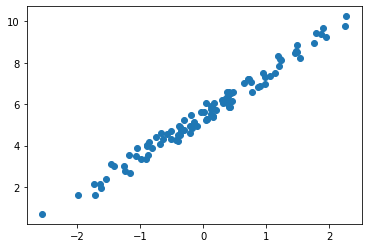

In [1]:
# 토이 데이터셋
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # 시드값 고정
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.rand(100,1) # y에 무작위 노이즈 추가

plt.scatter(x,y)
plt.show()

위 토이 데이터셋의 x와 y는 선형 관계이나 y에 노이즈가 추가되어 있음  
  
x값이 주어지면 y값을 예측하는 모델(수식)을 만들어야 함  
  
이 문제에서 x와 y가 선형 관계라고 가정하기 때문에 $y=Wx+b$로 표현할 수 있음  
회귀에서는 데이터와 예측치의 차이인 잔차(residual)을 최소화하는 직선 $y=Wx+b$를 찾는 것이 목표이며,  
예측치(모델)와 데이터의 오차를 나타내는 지표는 다음 식으로 정의함  
  
$L=\frac{1}{N}\sum^N_{i=1}(f(x_i)-y_i)^2$  
  
이는 평균 제곱 오차(mean squared error)로 총 N개의 점에 대해($x_i, y_i$)의 각 점에서 제곱 오차를 구한 다음 모두 더하고 $\frac{1}{N}$을 곱하여 평균을 구한 값임  
선형 회귀에서는 손실 함수로 평균 제곱 오차를 이용함  
  
따라서, 손실 함수의 출력을 최소화하는 W와 b를 찾는 함수 최적화 문제라고 할 수 있음  
이를 경사하강법을 이용하여 구현하면 다음과 같음

In [2]:
import numpy as np
from dezero import Variable
import dezero.functions as F

# 토이 데이터셋
np.random.seed(0) 
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.rand(100,1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1,1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)
    
    W.cleargrad()
    b.cleargrad()
    loss.backward()
    
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

variable([[0.47225324]]) variable([1.12285597]) variable(35.639227142413375)
variable([[0.83479198]]) variable([2.01549184]) variable(22.352525843294014)
variable([[1.11273871]]) variable([2.72526399]) variable(14.03968744103063)
variable([[1.32552745]]) variable([3.28975702]) variable(8.835506148369609)
variable([[1.48818042]]) variable([3.73880616]) variable(5.575369864173143)
variable([[1.61230024]]) variable([4.09609987]) variable(3.531709851601136)
variable([[1.70684062]]) variable([4.38045017]) variable(2.2497326621513265)
variable([[1.77870475]]) variable([4.60679956]) variable(1.4449848960136873)
variable([[1.83320966]]) variable([4.78701945]) variable(0.9394443499151088)
variable([[1.87444636]]) variable([4.93054341]) variable(0.6216269868304265)
variable([[1.90555891]]) variable([5.04486931]) variable(0.4216716133545497)
variable([[1.92896069]]) variable([5.13595788]) variable(0.2957702354273312)
variable([[1.94650174]]) variable([5.20854881]) variable(0.21643290401114082)
va

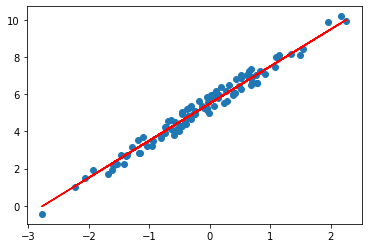

In [6]:
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.rand(100,1)
y_n = x * W.data + b.data

plt.scatter(x,y)
plt.plot(x,y_n,color='red')

위에서 사용한 predict 함수는 matmul 함수를 사용하여 행렬 곱을 계산하므로 여러 데이터를 모아서 한 번에 계산할 수 있음  
\* x.shape[1]과 W.shape[0]이 일치해야 행렬 곱이 제대로 계산됨

# [보충] DeZero의 mean_squared_error 함수  

<img src='./img/4/mse.png' width=700>

위에서 구현한 평균 제곱 오차를 구하는 함수에서는 위 계산 그래프에서 중간에 나오는 이름 없는 변수 세 개가 계산 그래프가 존재하는 동안 메모리에 계속 살아있음  
메모리를 덜 사용할 수 있도록 forward 메서드의 범위를 벗어나는 순간 메모리에 삭제되도록 수정하여 dezero/functions.py에 추가

~~~python
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0, x1
        y = (diff ** 2).sum() / len(diff)
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1
    
def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)
~~~

# 43단계 신경망

42단계에서 선형 회귀로 수행한 계산은 (손실 함수를 제외하면) 입력 x와 매개변수 W 사이에서 행렬 곱을 구하고, b를 더해줬음  
이 변환을 선형 변환(linear transformation) 혹은 아핀 변환(affine transformation)이라고 함  
(정확히는 선형 변환은 b는 포함되지 않으나 신경망 분야에서는 b 더하는 계산까지 포함하는 연산을 선형 변환이라고 부르는 것이 일반적)  
선형 변환은 신경망에서는 완전연결계층(fully connected layer)에 해당하며,  
매개변수 W는 가중치(Weight), 매개변수 b는 편향(bias)이라고 함  
  
위 계산을 수행하는 linear 함수 구현하는 방법은 두 가지가 있음  
  
__첫 번째 방법. linear_simple 함수__  
  
<img src='./img/4/linearregression_1.png' width=500>  
  
변수 t의 데이터는 역전파 시 필요하지 않음  
따라서 $y=t+b$ 계산 후 t.data=None으로 설정하여 t의 데이터를 메모리에서 삭제

~~~python
def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t
    
    y = t + b
    t.data = None # t의 데이터 삭제
    return y
~~~

__두 번째 방법. linear_simple 함수__  
  
<img src='./img/4/linearregression_2.png' width=300>  
  
Function 클래스를 상속하여 Linear 클래스를 구현  
중간 결과가 Variable 인스턴스로 보존되지 않기 때문에 순전파 시 사용하던 중간 데이터는 순전파가 끝나는 즉시 삭제됨   

~~~python
class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W)
        if b is not None:
            y += b
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb


def linear(x, W, b=None):
    return Linear()(x, W, b)
~~~

비선형 데이터셋

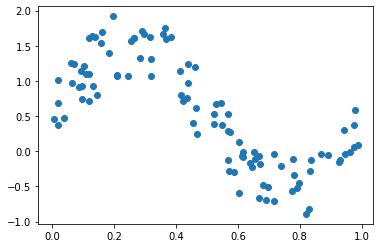

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1) # 데이터 생성에 sin 함수 이용
plt.scatter(x, y)

비선형 데이터셋은 선형 회귀로는 풀 수 없음  
신경망에선 선형 변환의 출력에 비선형 변환을 텐서에 각 원소에 적용  
비선형 변환을 활성화 함수(activation function)이라고 하며, 대표적으로 ReLU 함수, 시그모이드 함수 등이 있음  
  
이번 예시에서 활성화 함수로 시그모이드 함수를 사용!  
시그모이드 함수의 식은 다음과 같음  
$y = \frac{1}{1+exp(-x)}$

~~~python
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y
~~~

Function 클래스를 상속한 Sigmoid 클래스 구현은 다음과 같음  
(이 방법으로 하면 클래스를 하나의 단위로 하여 기울기 계산 효율을 높일 수 있음)

~~~python
class Sigmoid(Function):
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * y * (1 - y)
        return gx


def sigmoid(x):
    return Sigmoid()(x)
~~~

__신경망 구현__  
  
일반적인 신경망은 '선형 변환$\rightarrow$활성화 함수$\rightarrow$선형 변환$\rightarrow$활성화 함수$\rightarrow$선형 변환$\rightarrow$...' 형태로 '선형 변환'과 '활성화 함수'를 순서대로 적용하여 연속적으로 변환을 수행함. 이것이 신경망 추론(predict) 코드  
  
신경망 학습에서는 추론을 처리한 후 손실 함수를 추가하고,  
손실 함수의 출력을 최소화하는 매개변수를 찾음  


variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.2475948546674987)
variable(0.23786120447054812)
variable(0.21222231333102923)
variable(0.1674218111783417)
variable(0.09681932619992654)
variable(0.07849528290602327)
variable(0.07749729552991153)
variable(0.07722132399559316)


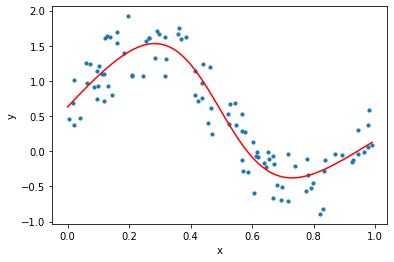

In [3]:
### 신경망 학습

import numpy as np
from dezero import Variable
import dezero.functions as F

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 1. 가중치 초기화
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 2. 신경망 추론
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# 3. 신경망 학습
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)
        
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

# 44단계 매개변수를 모아두는 계층

매개변수란 경사하강법 등의 최적화 기법에 의해 갱신되는 변수로, '가중치', '편향'이 해당됨  
  
매개변수를 담는 구조를 만들어 매개변수 관리를 자동화하기 위해 Parameter와 Layer라는 클래스를 구현  
  
__Pamameter 클래스 구현__  
  
~~~python
class Parameter(Variable):
    pass
~~~
  
Parameter 클래스를 dezero/core.py에 추가하고  
dezero/\_\_init__.py에 from dezero import Parameter 추가  
  

In [1]:
import numpy as np
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


__Layer 클래스 구현__  
  
Function 클래스와 마찬가지로 변수를 변환하는 클래스이나,  
매개변수를 유지하고 매개변수를 사용하여 변환을 함  
Layer 클래스를 기반 클래스로 두고 구체적인 변환은 자식 클래스에서 구현  
dezero/layers.py 에 저장
  
~~~python
from dezero.core import Parameter

class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)
~~~  
  
\_params 인스턴스 변수는 매개변수를 보관함, 타입이 집합(set)으로 원소들에 순서가 없고, ID가 같은 객체를 중복 저장할 수 없음  
 

In [5]:
from dezero.layers import Layer
from dezero import Variable
from dezero import Parameter
import numpy as np

layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('-----------------')

for name in layer._params:
    print(name, layer.__dict__[name])

{'p1', 'p2'}
-----------------
p1 variable(1)
p2 variable(2)


Parameter 인스턴스를 보유하고 있는 인스턴스 변수 이름만 layer.\_params에 추가되며, 인스턴스 변수 \_\_dict__에는 모든 모든 인스턴스 변수가 딕셔너리 타입으로 저장됨  
  
Layer 클래스에 다음 4개의 메서드 추가  
  
~~~python
import weakref

class Layer:
    ...
    
    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, inputs): # 자식 클래스에서 구현
        raise NotImplementedError()
        
    def params(self):
        for name in self._params:
            yield self.__dict__[name]
            
    def cleargrads(self): # 기울기 재설정
        for param in self.params():
            param.cleargrad()
~~~  
  
< 참고 >  
  
return은 처리를 종료하고 값을 반환하는 반면 yield는 처리를 일시 중지하고 값을 반환하므로 작업을 재개할 수 있음  
따라서, yield를 for문과 함께 사용하여 매개변수를 순차적으로 꺼낼 수 있음

__Linear 클래스 구현__  
  
~~~python
import numpy as np
import dezero functions as F
from dezero.core import Parameter

class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()
        
        I, O = in_size, out_size
        W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I)
        self.W = Parameter(W_data, name ='W')
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(0, dtype=dtype), name='b')
    
    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y
~~~

가중치를 초기화 메서드가 아닌 forward 메서드에서 생성함으로써 Linear 클래스의 입력 크기를 사용자가 지정하지 않고 자동으로 결정되도록 수정

~~~python
import numpy as np
import dezero.functions as F
from dezero.core import Parameter

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()        
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype
        
        self.W = Parameter(None, name='W')
        if self.in_size is not None: # in_size가 지정되어 있지 않다면 나중으로 연기
            self._init_W()
            
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')
            
    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data
        
    def forward(self, x):
        # 데이터를 흘려보내는 시점에 가중치 초기화
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()
            
        y = F.linear(x, self.W, self.b)
        return y
~~~

Layer를 이용한 신경망 구현

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F
import dezero.layers as L # L로 임포트

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10) # 출력 크기 지정
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    
    l1.cleargrads()
    l2.cleargrads()
    loss.backward()
    
    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
            
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350168)
variable(0.1231190572064935)
variable(0.07888166506355149)
variable(0.07655073683421632)
variable(0.07637803086238223)
variable(0.0761876413118557)


다음 단계에서는 여러 Layer를 개별적으로 다루지 않고 하나의 클래스로 묶어서 관리하도록 개선!

# 45단계 계층을 모아두는 계층

__Layer 클래스에 다른 Layer도 담을 수 있도록 확장__  
- Layer 인스턴스의 이름도 \_params에 추가
- params 메서드, \_params에서 name을 꺼내 그 name에 해당하는 객체를 obj로 꺼내며,  
    obj가 Layer라면 Layer에서 매개변수를 재귀적으로 꺼냄
  
< 참고 >  
  
yield를 사용한 함수를 제너레이터(generator)라고 하며, 제너레이터를 사요하여 또 다른 제너레이터를 만들 때는 yield from을 사용함  
  
~~~python
class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # 1. Layer도 추가
            self._params.add(name)
        super().__setattr__(name, value)
        
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]
            
            if isinstance(obj, Layer): # 2. Layer에서 매개변수 꺼내기
                yield from obj.params()
            else:
                yield obj
~~~  
  


__새로운 Layer 클래스를 사용하여 신경망 구현__  
  
model = Layer()에서 인스턴스를 생성하여 model의 인스턴스 변수로 Linear 인스턴스를 추가  
따라서 model.params()로 model 내에 존재하는 모든 매개변수에 접근하거나  
model.cleargrads()로 모든 매개변수의 기울기를 재설정하는 식으로  
신경망에서 사용하는 매개변수를 한꺼번에 관리할 수 있음

In [2]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5) # 출력 크기만 지정
model.l2 = L.Linear(3)

# 추론을 수행하는 함수
def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 모든 매개변수에 접근
for p in model.params():
    print(p)
    
# 모든 매개변수의 기울기를 재설정
model.cleargrads()

variable([0. 0. 0. 0. 0.])
variable(None)
variable([0. 0. 0.])
variable(None)


__Layer 클래스를 상속하여 모델 전체를 하나의 '클래스'로 정의하는 더 편리한 방식으로 구현__  
  
모델을 클래스 단위로 정의한 객체지향식 모델 정의 방법은 체이너가 최초로 제안했고, 그 후 파이토치와 텐서플로 등 많은 다른 프레임워크에서 보편적으로 사용하는 방식으로 굳어졌음!
  
~~~python
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
~~~

__Model 클래스 구현__  
  
모델 : 복잡한 패턴이나 규칙이 숨어있는 현상을 수식을 사용하여 단순하게 표현한 것  
  
~~~python
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
             y = self.forward(*inputs)
             return utils.plot_dot_graph(y, verbose=True, to_file=to_file)
~~~

dezero/models.py 추가 및 dezero/\_\_init__.py에 from dezero.models import Model 추가

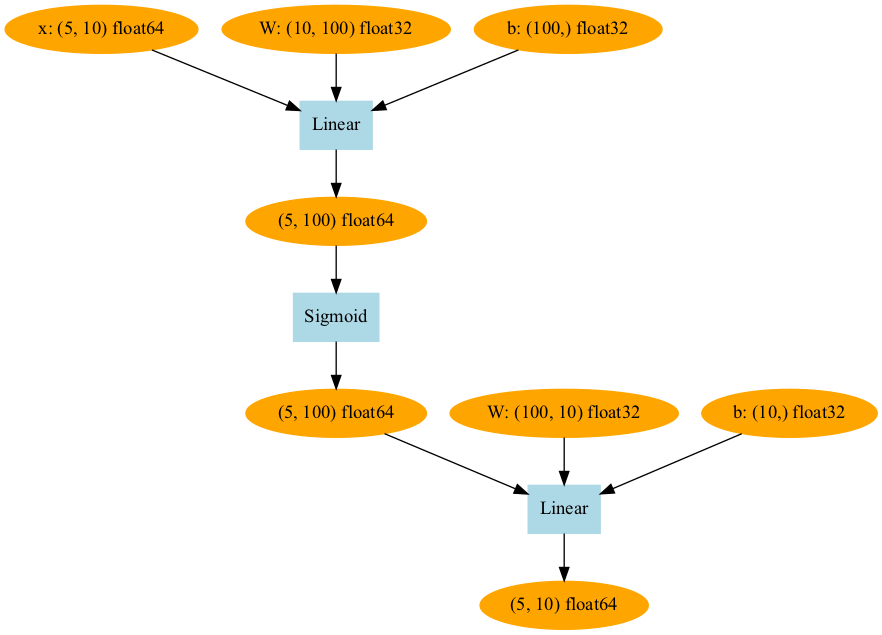

In [1]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x) # 계산 그래프

__Model 클래스를 이용하여 sin 함수 데이터셋 회귀문제 풀기__  

In [4]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

# 데이터셋 생성
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 하이퍼파라미터 설정
lr = 0.2
max_iter = 10000
hidden_size = 10

# 모델 정의
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(hidden_size, 1)

# 학습 시작
for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0 :
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350168)
variable(0.1231190572064935)
variable(0.07888166506355149)
variable(0.07655073683421632)
variable(0.07637803086238223)
variable(0.0761876413118557)


MLP(Multi-Layer Perceptron, '다층 퍼셉트론') 클래스 구현  
  
앞에서는 2층 신경망을 구현했으나,  
이번에는 더 범용적인 다층 완전연결계층 신경망 구현  
\* MLP는 완전연결계층 신경망의 별칭으로 흔히 쓰임  
  
dezero/models.py 에 추가

~~~python
import dezero.functions as F
import dezero.layers as L

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid): # fc_output_sizes의 fc는 fully connection(완전연결)의 약자
        super().__init__()
        self.activation = activation
        self.layers = []
        
        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)
            
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)
~~~

In [1]:
from dezero.models import MLP


model = MLP((10, 1)) # 2층
model = MLP((10, 20, 30, 40, 1)) # 5층

# 46단계 Optimizer로 수행하는 매개변수 갱신

__Optimizer 클래스 구현__  
  
매개변수 갱신 작업을 모듈화하고 쉽게 다른 모듈로 대체할 수 있는 구조를 만들기 위해  
매개변수 갱신을 위한 기반 클래스인 Optimizer 클래스 구현  
구체적인 최적화 기법은 Optimizer 클래스를 상속한 자식 클래스에서 구현  
  
- setup 메서드 : 매개변수를 갖는 클래스(Model 또는 Layer)를 인스턴스 변수인 target으로 설정  
  
- update_one 메서드 : 구체적인 매개변수 갱신 수행, 이 메서드는 Optimizer의 자식 클래스에서 재정의해야 함  
  
- add_hook 메서드 : 가중치 감소, 기울기 클리핑 등의 전처리를 수행할 수 있게 하는 함수  
  
dezero/optimizers.py 추가

~~~python
class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []
        
    def setup(self, target):
        self.target = target
        return self
    
    def update(self):
        # None 이외의 매개변수를 리스트에 모아둠
        params = [p for p in self.target.params() if p.grad is not None]
        
        # 전처리(옵션)
        for f in self.hooks:
            f(params)
            
        # 매개변수 갱신
        for param in params:
            self.update_one(param)
            
    def update_one(self, param):
        raise NotImplementedError()
        
    def add_hook(self, f):
        self.hooks.append(f)
~~~

__SGD(Stochastic Gradient Descent, 확률적경사하강법) 클래스 구현__  
  
경사하강법으로 매개변수 갱신하는 클래스 구현  
  
dezero/optimizers.py에 추가  
  
~~~python
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr
        
    def update_one(self, param):
        param.data -= self.lr * param.grad.data
~~~

SGD 클래스를 사용한 sin 함수 데이터셋 회귀문제 풀기

In [1]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

# 또는 다음처럼 한 줄로 합칠 수 있음
# optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    optimizer.update() # 매개변수 갱신
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350168)
variable(0.1231190572064935)
variable(0.07888166506355149)
variable(0.07655073683421632)
variable(0.07637803086238223)
variable(0.0761876413118557)


__최적화 기법 Momentum 클래스 구현__  
  
Momentum 수식  
  
$v \leftarrow \alpha v-\eta\frac{\partial{L}}{\partial{W}}$  
  
$W \leftarrow W + v$  
  
- W : 갱신할 가중치 매개변수
- $\frac{\partial{L}}{\partial{W}}$ : W에 관한 손실함수 L의 기울기
- $\eta$ : 학습률
- v : 속도  
  
위 식은 물체가 기울기 방향으로 힘을 받아 가속된다는 물리 법칙을 나타내며,  
이 식에 의해 속도만큼 위치(매개변수)가 이동함  
$\alpha v$항은 물체가 아무런 힘을 받지 않을 때 서서히 감속시키는 역할을 하며, $\alpha$의 값은 0.9 등으로 설정함  

~~~python
import numpy as np

class MomentumSGD(Optimizers):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {} # 속도
        
    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)
            
        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr *param.grad.data
        param.data += v
~~~

__AdaGrad 클래스 구현__

(밑바닥부터 시작하는 딥러닝 6장 참고)  
신경망 학습에서는 학습률($\eta$) 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않음  
  
학습률 감소(learning rate decay) : 학습을 진행하면서 학습률을 점차 줄여가는 방법,  
처음에는 크게 학습하다가 조금씩 작게 학습  
  
AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행함  
  
$h \leftarrow h+\frac{\partial{L}}{\partial{W}}	\odot \frac{\partial{L}}{\partial{W}}$  

$W \leftarrow W-\eta\frac{1}{\sqrt{h}}\frac{\partial{L}}{\partial{W}}$  
  
- W : 갱신할 가중치 매개변수  
- $\frac{\partial{L}}{\partial{W}}$ : W에 대한 손실 함수의 기울기
- $\eta$ : 학습률
- h : 기존 기울기 값을 제곱하여 계속 더해줌($\odot$기호는 행렬의 원소별 곱셈을 의미),  
    그리고 매개변수를 갱신할 때 $\frac{1}{\sqrt{h}}$을 곱해 학습률을 조정함  
    매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻  
    다시 말해 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻함

~~~python
class AdaGrad(Optimizer):
    def __init__(self, lr=0.001, eps=1e-8):
        super().__init__()
        self.lr = lr
        self.eps = eps
        self.hs = {}

    def update_one(self, param):
        h_key = id(param)
        if h_key not in self.hs:
            self.hs[h_key] = np.zeros_like(param.data)
            
        lr = self.lr
        eps = self.eps
        grad = param.grad.data
        h = self.hs[h_key]

        h += grad * grad
        param.data -= lr * grad / (np.sqrt(h) + eps)
~~~

__AdaDelta 클래스 구현__

AdaGrad의 gradient vanishing 문제를 보완하기 위해 제안된 옵티마이저로,  
스텝 크기를 학습률이 아닌 스텝 크기의 변화 값의 제곱하여 지수 평균값을 계산함  

~~~python
class AdaDelta(Optimizer):
    def __init__(self, rho=0.95, eps=1e-6):
        super().__init__()
        self.rho = rho
        self.eps = eps
        self.msg = {}
        self.msdx = {}

    def update_one(self, param):
        key = id(param)
        if key not in self.msg:
            self.msg[key] = np.zeros_like(param.data)
            self.msdx[key] = np.zeros_like(param.data)

        msg, msdx = self.msg[key], self.msdx[key]
        rho = self.rho
        eps = self.eps
        grad = param.grad.data

        msg *= rho
        msg += (1 - rho) * grad * grad
        dx = np.sqrt((msdx + eps) / (msg + eps)) * grad
        msdx *= rho
        msdx += (1 - rho) * dx * dx
        param.data -= dx
~~~

__Adam 클래스 구현__

(밑바닥부터 시작하는 딥러닝 6장 참고)  
모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보임
AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정했음
이 두 기법을 융합한 듯한 방법이 Adam
또, 하이퍼파라미터의 '편향 보정'이 진행된다는 특징도 있음



~~~python
class Adam(Optimizer):
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__()
        self.t = 0
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.ms = {}
        self.vs = {}

    def update(self, *args, **kwargs):
        self.t += 1
        super().update(*args, **kwargs)

    @property
    def lr(self):
        fix1 = 1. - math.pow(self.beta1, self.t)
        fix2 = 1. - math.pow(self.beta2, self.t)
        return self.alpha * math.sqrt(fix2) / fix1

    def update_one(self, param):

        key = id(param)
        if key not in self.ms:
            self.ms[key] = np.zeros_like(param.data)
            self.vs[key] = np.zeros_like(param.data)

        m, v = self.ms[key], self.vs[key]
        beta1, beta2, eps = self.beta1, self.beta2, self.eps
        grad = param.grad.data

        m += (1 - beta1) * (grad - m)
        v += (1 - beta2) * (grad * grad - v)
        param.data -= self.lr * m / (np.sqrt(v) + eps)
~~~

# 47단계 소프트맥스 함수와 교차 엔트로피 오차

지금까지 다룬 회귀 문제가 아닌 다중 클래스 분류(multi-class classification) 문제를 다루기 위한 사전 준비  
  
__get_item 함수__  
  
구현은 부록 B 참고(dezero/functions.py 에 추가함)  
  
get_item 함수는 Variable의 다차원 배열 중 일부를 슬라이스하여 뽑아줌  
역전파는 원래의 다차원 배열에서 데이터가 추출된 위치에 해당 기울기를 설정하고, 그 외에는 0으로 설정함  
  
\* 다차원 배열의 일부를 추출하는 작업을 '슬라이스'라고 함
  
<img src='./img/4/getitem.png' width=500>

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.get_item(x, 1)
print(y)

variable([4 5 6])


In [2]:
y.backward() # 역전파
print(x.grad)

variable([[0. 0. 0.]
          [1. 1. 1.]])


인덱스를 반복 지정하여 동일한 원소를 여러 번 빼낼 수 있음 

In [3]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
indices = np.array([0,0,1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


get_item 함수를 Variable의 메서드로도 사용할 수 있도록 특수 메서드로 설정

In [5]:
Variable.__getitem__ = F.get_item # Variabledml aptjemfh tjfwjd

y = x[1]
print(y)

y = x[:,2]
print(y)

variable([4 5 6])
variable([3 6])


__소프트맥스 함수__

이미 구현한 신경망을 그대로 다중 클래스 분류에서도 사용할 수 있음  
  
ex) 입력 데이터 차원 수 2, 3개의 클래스로 분류하는 문제

In [1]:
from dezero.models import MLP
import numpy as np

model = MLP((10,3)) # 2층으로 이루어진 완전연결계층

In [2]:
x = np.array([[0.2, -.04]])
y = model(x)
print(y)

variable([[-0.26106594 -0.59399635  0.34780657]])


출력된 3차원 벡터의 원소 각각이 하나의 클래스에 해당하며,  
출력된 벡터에서 값이 가장 큰 원소의 인덱스가 이 모델이 분류한(예측한) 클래스가 됨  


여러 개의 입력 데이터를 한번에 처리할 수 있음 
  
ex) 입력 데이터 4개 한번에 처리

In [3]:
x = np.array([[0.2, -0.4],[0.3, 0.5],[1.3,-3.2],[2.1,0.3]])
y = model(x)
print(y)

variable([[-0.22418196 -0.6658777   0.38897529]
          [-0.33190307 -0.44997993  0.27934484]
          [-0.01702671 -0.66961947  0.5498054 ]
          [-0.62322019 -0.09944109  0.23457456]])


y의 형상은 (4,3)이 되며, i번째 입력 데이터는 x[i]가 되고, 그에 대응하는 출력은 y[i]가 됨

신경망의 출력은 단순히 수치이지만,  
소프트맥스 함수를 통해 확률로 변환할 수 있음  
소프트맥스 함수의 수식은 다음과 같음  
  
$p_k = \frac{exp(y_k)}{\sum_{i=1}^n exp(y_1}$  
  
여기서, $y_k$는 입력, n은 클래스 수이며, k번째 출력 $p_k$를 구함  
  
소프트맥스 함수는 $0\leq p_i\leq 1$이고, $p_1+p_2+\cdots+p_n=1$이 성립하여  
$(p_1, p_2, \cdots, p_n)$의 원소 각각을 확률로 해석할 수 있음  
  
샘플 데이터가 하나인 경우에 한정한 소프트맥스 함수의 구현은 다음과 같음

In [4]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [5]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[-0.22418196 -0.6658777   0.38897529]])
variable([[0.28659893 0.18426742 0.52913365]])


소프트맥스 함수의 계산은 지수 함수로 이뤄져 결과값이 너무 커지거나 작아지기 쉬우므로 오버플로 문제에 잘 대처해야 함.  
밑바닥부터 시작하는 딥러닝 3장 소프트맥스 함수 구현시 주의점 참고!

__배치 데이터도 처리할 수 있는 소프트맥스 함수 구현__

~~~python
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis=axis, keepdims=True)
    return y / sum_y
~~~

__Function 클래스를 상속하여 Softmax 클래스로 구현하고 파이썬 함수 softmax 구현__

~~~python
class Softmax(Function):
    def __init__(self, axis=1):
        self.axis = axis

    def forward(self, x):
        y = x - x.max(axis=self.axis, keepdims=True) # 오버플로 대책
        y = np.exp(y)
        y /= y.sum(axis=self.axis, keepdims=True)
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = y * gy
        sumdx = gx.sum(axis=self.axis, keepdims=True)
        gx -= y * sumdx
        return gx


def softmax(x, axis=1):
    return Softmax(axis)(x)
~~~

__교차 엔트로피 오차__

선형 회귀에서는 손실 함수로 평균 제곱 오차를 이용하나,  
다중 클래스 분류에서는 교차 엔트로피 오차(cross entropy error)를 사용함  
  
$L = -\sum_{k}t_klogp_k$  
  
- $t_k$ : k 차원째 정답 데이터의 값. 원핫 벡터(one hot vector)로 표현되어 있음(해당되면 1, 아니면 0)  
  
- $p_k$ : 신경망에서 소프트맥스 함수를 적용한 후의 출력  
  
이는 정답 클래스에 해당하는 번호가 t로 주어지면 해당하는 번호의 확률 p를 추출함으로써 다음과 같이 계산할 수 있음  
  
$L = -logp[t]$  
  
- p[t] : 벡터 p에서 t번째 요소만을 추출한다는 뜻  

  


교차 엔트로피 오차의 구현은 다음과 같음  
  
- x : 신경망에서 소프트맥스 함수를 적용하기 전의 출력
- t : 정답 레이블(원핫 벡터가 아닌 정답 클래스 번호(레이블))

log_p[np.arange(N), t.data]코드는 log_p[0, t.data[0]], log_p[1, t.data[1]], ...와 정답 데이터(t.data)에 대응하는 모델의 출력을 구하고, 그 값을 1차원 배열에 담아줌

~~~python
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    
    p = softmax(x)
    p = clip(p, 1e-15, 1.0) # log(0)을 방지하기 위해 p의 값을 1e-15 이상으로 설정
    log_p = log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y



class Max(Function):
    def __init__(self, axis=None, keepdims=False):
        self.axis = axis
        self.keepdims = keepdims

    def forward(self, x):
        y = x.max(axis=self.axis, keepdims=self.keepdims)
        return y

    def backward(self, gy):
        x = self.inputs[0]
        y = self.outputs[0]()  # weakref

        shape = utils.max_backward_shape(x, self.axis)
        gy = reshape(gy, shape)
        y = reshape(y, shape)
        cond = (x.data == y.data)
        gy = broadcast_to(gy, cond.shape)
        return gy * cond


class Min(Max):
    def forward(self, x):
        y = x.min(axis=self.axis, keepdims=self.keepdims)
        return y


def max(x, axis=None, keepdims=False):
    return Max(axis, keepdims)(x)


def min(x, axis=None, keepdims=False):
    return Min(axis, keepdims)(x)


class Clip(Function):
    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max

    def forward(self, x):
        y = np.clip(x, self.x_min, self.x_max)
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = (x.data >= self.x_min) * (x.data <= self.x_max)
        gx = gy * mask
        return gx


def clip(x, x_min, x_max):
    return Clip(x_min, x_max)(x)
~~~

clip 함수는 x의 원소가 x_min 이하이면 x_min으로 변환, x_max 이상이면 x_max로 변환해줌

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F
from dezero.models import MLP

model = MLP((10,3)) 
x = np.array([[0.2, -0.4],[0.3, 0.5],[1.3,-3.2],[2.1,0.3]])
t = np.array([2,0,1,0]) # 정답 레이블
y = model(x)
loss = F.softmax_cross_entropy_simple(y, t)
print(loss)

variable(1.059585216699765)


__Function 클래스를 상속하여 SoftmaxCrossEntropy 클래스로 구현__

~~~python
class SoftmaxCrossEntropy(Function):
    def forward(self, x, t):
        N = x.shape[0]
        log_z = utils.logsumexp(x, axis=1)
        log_p = x - log_z
        log_p = log_p[np.arange(N), t.ravel()]
        y = -log_p.sum() / np.float32(N)
        return y

    def backward(self, gy):
        x, t = self.inputs
        N, CLS_NUM = x.shape

        gy *= 1/N
        y = softmax(x)
        # convert to one-hot
        t_onehot = np.eye(CLS_NUM, dtype=t.dtype)[t.data]
        y = (y - t_onehot) * gy
        return y


def softmax_cross_entropy(x, t):
    return SoftmaxCrossEntropy()(x, t)
~~~

# 48단계 다중 클래스 분류

__스파이럴 데이터셋__  
  
dezero/datasets.py에 들어있는 스파이럴 데이터셋 확인

In [1]:
import dezero

x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


3 클래스 분류 문제이며, 스파이럴 데이터셋을 그래프로 표현하면 아래 그림과 같이 소용돌이 모양으로 분포함      

<img src='./img/4/spiral_dataset.png' width=300>

__클래스 분류 학습 코드__  
  
데이터가 많을 때는 모든 데이터를 한꺼번에 처리하는 대신 조금씩 무작위로 모아서 처리함  
이 때의 '데이터 뭉치'를 미니배치라고 함  

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

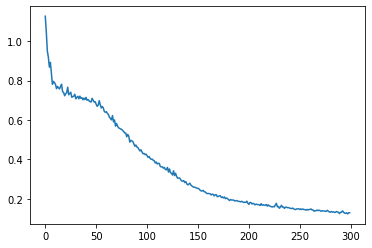

In [2]:
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
import matplotlib.pyplot as plt

# 1. 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 2. 데이터 읽기 / 모델, 옵티마이저 생성
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size) # 소수점 반올림
avg_loss_li = []

for epoch in range(max_epoch):
    # 3. 데이터셋의 인덱스 뒤섞기
    index = np.random.permutation(data_size)
    sum_loss = 0
    
    for i in range(max_iter):
        # 4. 미니배치 생성
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]
        
        # 5. 기울기 산출 / 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(batch_t)
        
    # 6. 에포크마다 학습 경과 출력
    avg_loss = sum_loss / data_size
    avg_loss_li.append(avg_loss)
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))
    
plt.plot(np.arange(max_epoch), avg_loss_li) # 에폭별 loss 시각화ㅁ
plt.show()

# 49단계 Dataset 클래스와 전처리

데이터셋의 크기가 커졌을 때 데이터를 하나의 ndarray 인스턴스로 처리하면 모든 원소를 한꺼번에 메모리에 올리게 됨  
이러한 문제에 대응할 수 있도록 데이터셋 전용 클래스인 Dataset 클래스 구현  
또한, Dataset 클래스를 이용함으로써 통일된 인터페이스로 데이터셋을 다룰 수 있음
  
__Dataset 클래스 구현__  
  
Dataset 클래스는 기반 클래스로서의 역할을 하고, 실제 사용하는 데이터셋은 이를 상속하여 구현  
prepare 메서드는 자식클레스에서 데이터 준비 작업을 구현  

  
~~~python
import numpy as np
class Dataset:
    def __init__(self, train=True):
        self.train = train
        self.data = None
        self.label = None
        self.prepare()
    
    def __getitem__(self, index):
        assert np.isscalar(index) # index는 정수(스칼라)만 지원
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index], self.label[index]
        
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass
~~~

__스파이럴 데이터셋 구현__  
  
~~~python 
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)
~~~

In [22]:
import dezero

train_set = dezero.datasets.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


__데이터 이어 붙이기__  
  
신경망을 학습시킬 때는 데이터셋 중 일부를 미니배치로 꺼내 사용함  

In [23]:
train_set = dezero.datasets.Spiral()

batch_index = [0,1,2] # 0에서 2번째까지의 데이터를 꺼냄
batch = [train_set[i] for i in batch_index]

# batch = [(data_0, label_0), (data_1, label_1), (data_2, label_2)]

이 데이터를 DeZero의 신경망에 입력하려면 하나의 ndarray 인스턴스로 변환해야 함  
아래 코드와 같이 하나의 ndarray 인스턴스로 이어붙일 수 있음

In [25]:
x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


__Spiral 클래스를 사용한 학습__

In [26]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral()
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0
    
    for i in range(max_iter):
        # 미니배치 꺼내기(수정)
        batch_index = index[i * batch_size : (i+1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])
        
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(batch_t)
        
    # 에포크마다 손실 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch+1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

__데이터 전처리(및 데이터 확장)에 대응하기 위해 Dataset 클래스에 전처리 기능 추가__  
  
transform과 target_transform이라는 새로운 인수를 받음  
이 인수들은 호출 가능한 객체(ex. 파이썬 함수 등)를 받음  


~~~python
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train = train
        self.transform = transform # 추가
        self.target_transform = target_transform # 추가
        if self.transform is None: # 추가
            self.transform = lambda x: x
        if self.target_transform is None: # 추가
            self.target_transform = lambda x: x
            
        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index) 
        if self.label is None:
            return self.transform(self.data[index]), None # 수정
        else:
            return self.transform(self.data[index]),\ # 수정
                   self.target_transform(self.label[index])

    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass
~~~

전처리 예시

In [27]:
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform=f)

__자주 사용되는 전처리 함수__  
  
dezero/transforms.py 에 저장되어 있음

__정규화__

~~~python
class Normalize:
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std

    def __call__(self, array):
        mean, std = self.mean, self.std

        if not np.isscalar(mean):
            mshape = [1] * array.ndim
            mshape[0] = len(array) if len(self.mean) == 1 else len(self.mean)
            mean = np.array(self.mean, dtype=array.dtype).reshape(*mshape)
        if not np.isscalar(std):
            rshape = [1] * array.ndim
            rshape[0] = len(array) if len(self.std) == 1 else len(self.std)
            std = np.array(self.std, dtype=array.dtype).reshape(*rshape)
        return (array - mean) / std
~~~

In [28]:
from dezero import transforms

f = transforms.Normalize(mean=0.0, std=2.0)
train_set = dezero.datasets.Spiral(transform=f)

아래 Compose 클래스를 이용하여 여러 변환 처리를 연달아 수행하는 것도 할 수 있음  
transforms.Compose 클래스는 주어진 변환 목록을 앞에서부터 순서대로 처리함

~~~python
class Compose:
    def __init__(self, transforms=[]):
        self.transforms = transforms

    def __call__(self, img):
        if not self.transforms:
            return img
        for t in self.transforms:
            img = t(img)
        return img
~~~

In [29]:
f = transforms.Compose([transforms.Normalize(mean=0.0, std=2.0),
                       transforms.AsType(np.float64)])

# 50단계 미니배치를 뽑아주는 DataLoader

반복자(iterator) : 원소를 반복하여 꺼내줌  
파이썬의 반복자는 리스트나 튜플 등 여러 원소를 담고 있는 데이터 타입으로부터 데이터를 순차적으로 추출함  

In [30]:
t = [1,2,3]
x = iter(t) # 리스트를 반복자로 변환
next(x)

1

In [31]:
next(x)

2

In [32]:
next(x)

3

In [33]:
next(x) # 더 꺼낼 원소가 없음

StopIteration: 

반복자 클래스 구현

In [34]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()
            
        self.cnt += 1
        return self.cnt

In [35]:
obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


반복자 구조를 이용하여 __미니배치를 뽑아주는 DataLoader 클래스 구현__  
  
dezero.dataloaders.py 추가 및 dezero.\_\_init__.py에 from dezero.dataloaders import DataLoader 추가

~~~python
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        
        self.reset()
        
    def reset(self):
        self.iteration = 0 # 반복 횟수 초기화
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset)) # 데이터 뒤섞기
        else:
            self.index = np.arange(len(self.dataset))
            
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
            
        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i+1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])
        
        self.iteration += 1
        return x, t
    
    def next(self):
        return self.__next__()

~~~

DataLoader 클래스를 사용하여 미니배치 꺼내오기

In [1]:
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train = True)
test_set = Spiral(train = False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape) # x, t는 훈련 데이터
        break
        
    # 에포크 끝에서 테스트 데이터를 꺼냄
    for x, t in test_loader:
        print(x.shape, t.shape) # x, t는 테스트 데이터
        break

(10, 2) (10,)
(10, 2) (10,)


__accuracy 함수 구현__  
  
\* accuracy 함수는 ndarray 인스턴스를 사용해 수행하므로 미분은 할 수 없음

~~~python
def accuracy(y, t):
    y, t = as_variable(y), as_variable(t)
    
    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))
~~~

In [1]:
import numpy as np
import dezero.functions as F

y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

variable(0.6666666666666666)


__스파이럴 데이터셋 학습__

In [6]:
import numpy as np
import dezero
from dezero import Variable
from dezero import DataLoader
from dezero.models import MLP
from dezero import optimizers
import dezero.functions as F

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0
    
    for x, t in train_loader: # 1. 훈련용 미니배치 데이터
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t) # 2. 훈련 데이터의 인식 정확도
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)
        
        
    print('epoch: {}'.format(epoch + 1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))
    
    sum_loss, sum_acc = 0, 0
    with dezero.no_grad(): # 3. 기울기 불필요 모드
        for x, t in test_loader: # 4. 테스트용 미니배치 데이터
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) # 5. 테스트 데이터의 인식 정확도
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
            
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

epoch: 139
train loss: 0.1960, accuracy: 0.9433
test loss: 0.2216, accuracy: 0.9267
epoch: 140
train loss: 0.1981, accuracy: 0.9333
test loss: 0.2178, accuracy: 0.9233
epoch: 141
train loss: 0.1945, accuracy: 0.9367
test loss: 0.2194, accuracy: 0.9200
epoch: 142
train loss: 0.1969, accuracy: 0.9233
test loss: 0.2158, accuracy: 0.9233
epoch: 143
train loss: 0.1942, accuracy: 0.9333
test loss: 0.2127, accuracy: 0.9167
epoch: 144
train loss: 0.1886, accuracy: 0.9433
test loss: 0.2288, accuracy: 0.8933
epoch: 145
train loss: 0.1966, accuracy: 0.9133
test loss: 0.2103, accuracy: 0.9167
epoch: 146
train loss: 0.1899, accuracy: 0.9300
test loss: 0.2124, accuracy: 0.9100
epoch: 147
train loss: 0.1890, accuracy: 0.9400
test loss: 0.2104, accuracy: 0.9200
epoch: 148
train loss: 0.1865, accuracy: 0.9333
test loss: 0.2080, accuracy: 0.9267
epoch: 149
train loss: 0.1825, accuracy: 0.9367
test loss: 0.2285, accuracy: 0.8967
epoch: 150
train loss: 0.1890, accuracy: 0.9233
test loss: 0.2152, accuracy:

epoch: 283
train loss: 0.1142, accuracy: 0.9667
test loss: 0.1524, accuracy: 0.9433
epoch: 284
train loss: 0.1123, accuracy: 0.9700
test loss: 0.1500, accuracy: 0.9433
epoch: 285
train loss: 0.1192, accuracy: 0.9600
test loss: 0.1508, accuracy: 0.9467
epoch: 286
train loss: 0.1114, accuracy: 0.9600
test loss: 0.1471, accuracy: 0.9533
epoch: 287
train loss: 0.1109, accuracy: 0.9633
test loss: 0.1481, accuracy: 0.9567
epoch: 288
train loss: 0.1143, accuracy: 0.9533
test loss: 0.1534, accuracy: 0.9467
epoch: 289
train loss: 0.1126, accuracy: 0.9600
test loss: 0.1486, accuracy: 0.9500
epoch: 290
train loss: 0.1125, accuracy: 0.9733
test loss: 0.1485, accuracy: 0.9533
epoch: 291
train loss: 0.1136, accuracy: 0.9700
test loss: 0.1472, accuracy: 0.9500
epoch: 292
train loss: 0.1130, accuracy: 0.9600
test loss: 0.1495, accuracy: 0.9433
epoch: 293
train loss: 0.1118, accuracy: 0.9700
test loss: 0.1456, accuracy: 0.9533
epoch: 294
train loss: 0.1111, accuracy: 0.9600
test loss: 0.1591, accuracy:

에포크가 진행됨에 따라 손실이 낮아지고 인식 정확도는 상승함  
훈련과 테스트의 차이가 작으므로 모델이 과적합을 일으키지 않은 것을 알 수 있음

# 51단계 MNIST 학습

MNIST 데이터셋은 0\~9까지 숫자를 나타내는 손글씨 이미지 데이터로, 
입력 데이터 형상은 (1, 28, 28), 즉 1채널(그레이스케일)의 28$\times$28 픽셀 이미지 데이터이며,
레이블에는 정답 숫자의 인덱스(0\~9)가 들어 있음

In [1]:
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


In [2]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


입력 데이터 시각화

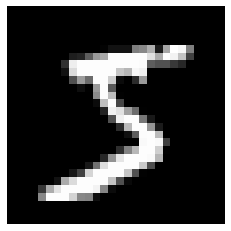

label: 5


In [3]:
import matplotlib.pyplot as plt

# 데이터 예시
x, t = train_set[0] # 0번째(data, label) 추출
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:',t)

데이터 전처리

In [5]:
def f(x):
    x = x.flatten() # 입력 데이터를 1열로 나열(평탄화) -> (784,) 형상
    x = x.astype(np.float32)
    x /= 255.0 # 0.0 ~ 1.0 사이 부동소수점
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

MNIST 클래스는 위 전처리가 기본으로 설정되어 있어 호출하면 자동으로 수행됨

MNIST 학습

In [7]:
import numpy as np
import dezero
from dezero import Variable
from dezero import DataLoader
from dezero.models import MLP
from dezero import optimizers
import dezero.functions as F


max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0
    
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)
        
    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))
    
    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
            
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9288, accuracy: 0.5452
test loss: 1.5528, accuracy: 0.7374
epoch: 2
train loss: 1.2940, accuracy: 0.7671
test loss: 1.0518, accuracy: 0.8122
epoch: 3
train loss: 0.9306, accuracy: 0.8143
test loss: 0.7999, accuracy: 0.8352
epoch: 4
train loss: 0.7443, accuracy: 0.8384
test loss: 0.6604, accuracy: 0.8527
epoch: 5
train loss: 0.6383, accuracy: 0.8521
test loss: 0.5795, accuracy: 0.8673


모델 개선  
  
1. 활성화 함수 : 시그모이드 함수 $\rightarrow$ ReLU 함수  
  
    여기서, ReLU(rectified linear unit) 함수는 입력이 0보다 크면 그대로 출력하고, 0 이하면 0을 출력하는 함수이며,  역전파에서는 순전파 시 신호를 통과시킨 원소라면 해당 역전파 시 기울기를 그대로 통과시키고, 순전파 시 신호가 막힌 원소(0 이하)는 기울기도 0이 됨  
    $h(x)= \Bigg\{ \begin{matrix} x (x>0)\\
    0 (x\geq0) \end{matrix}$  
  
~~~python
class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0) 
        return y
    
    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0
        gx = gy * mask
        return gx
    
def relu(x):
    return ReLU()(x)
~~~
  
2. 2층 신경망 $\rightarrow$ 3층 신경망
3. 최적화 기법 : SGD $\rightarrow$ Adam

In [1]:
import numpy as np
import dezero
from dezero import Variable
from dezero import DataLoader
from dezero.models import MLP
from dezero import optimizers
import dezero.functions as F


max_epoch = 10
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0
    
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)
        
    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))
    
    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
            
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.1916, accuracy: 0.9426
test loss: 0.1017, accuracy: 0.9686
epoch: 2
train loss: 0.0744, accuracy: 0.9766
test loss: 0.0825, accuracy: 0.9730
epoch: 3
train loss: 0.0477, accuracy: 0.9843
test loss: 0.0813, accuracy: 0.9755
epoch: 4
train loss: 0.0354, accuracy: 0.9886
test loss: 0.0659, accuracy: 0.9813
epoch: 5
train loss: 0.0275, accuracy: 0.9912
test loss: 0.0740, accuracy: 0.9806
epoch: 6
train loss: 0.0259, accuracy: 0.9911
test loss: 0.0772, accuracy: 0.9808
epoch: 7
train loss: 0.0217, accuracy: 0.9930
test loss: 0.0741, accuracy: 0.9813
epoch: 8
train loss: 0.0166, accuracy: 0.9948
test loss: 0.0737, accuracy: 0.9807
epoch: 9
train loss: 0.0168, accuracy: 0.9945
test loss: 0.0928, accuracy: 0.9792
epoch: 10
train loss: 0.0146, accuracy: 0.9953
test loss: 0.0805, accuracy: 0.9816


# APPENDIX B get_item 함수 구현(47단계 보충)

GetItem 클래스와 get_item 함수 코드  
  
forward(x) 메서드에서 단순히 원소를 추출함  

~~~python 
class GetItem(Function):
    def __init__(self, slices):
        self.slices = slices
        
    def forward(self, x):
        y = x[self.slices]
        return y
    
    def backward(self, gy):
        x, = self.inputs
        f = GetItemGrad(self.slices, x.shape)
        return f(gy)
    
def get_item(x, slices):
    return GetItem(slices)(x)
~~~

역전파 계산을 위해 GetItemGrad 클래스 구현  

~~~python
class GetItemGrad(Function):
    def __init__(self, slices, in_shape):
        self.slices = slices
        self.in_shape = in_shape
        
    def forward(self, gy):
        gx = np.zeros(self.in_shape)
        np.add.at(gx, self.slices, gy)
        return gx
    
    def backward(self, ggx):
        return get_item(ggx, self.slices)
~~~

다차원 배열을 슬라이스하여 여러 원소가 한 번에 추출된 경우 역전파 시 대응하는 기울기를 더해줘야 함  
np.add.at 함수로 기울기를 더해줌  
np.add.at 사용 예시는 다음과 같음

In [3]:
import numpy as np
a = np.zeros((2, 3))
a

array([[0., 0., 0.],
       [0., 0., 0.]])

In [4]:
b = np.ones(3,)
b

array([1., 1., 1.])

In [5]:
slices = 1
np.add.at(a, slices, b)
a

array([[0., 0., 0.],
       [1., 1., 1.]])